# Wine Quality Predictor

The first section of this project will predict using only numpy calculations

I will use Dropout, the Adam Optimizer and and Minibatch Sampling on this Model 

In [4]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

import seaborn as sns

In [21]:
# load the data from winequality dataset
# has about 5K entries
# data from https://machinelearningmastery.com/standard-machine-learning-datasets/

def loadDataset():
    data = np.genfromtxt("data/winequality-white.csv", delimiter = ";")
    data = np.delete(data, 0, axis = 0)
    
    train, test = data[:3500, :], data[3500:, :]
    
    train_x = train[:,:-1].T
    train_y = train[:,-1].reshape(1, train.shape[0])
    
    train_x = preprocessing.minmax_scale(train_x, axis = 1)
    train_y = preprocessing.minmax_scale(train_y, axis = 1)
    
    test_x = test[:,:-1].T
    test_y = test[:,-1].reshape(1, test.shape[0])
    
    test_x = preprocessing.minmax_scale(test_x, axis = 1)
    test_y = preprocessing.minmax_scale(test_y, axis = 1)
    
    return (train_x, train_y, test_x, test_y)
    

[[0.28       0.21       0.39       ... 0.35       0.22       0.19      ]
 [0.20540541 0.23783784 0.21621622 ... 0.37837838 0.23783784 0.27027027]
 [0.21686747 0.20481928 0.24096386 ... 0.60240964 0.21686747 0.18072289]
 ...
 [0.25454545 0.52727273 0.49090909 ... 0.51818182 0.6        0.53636364]
 [0.27380952 0.32142857 0.26190476 ... 0.33333333 0.36904762 0.21428571]
 [0.13333333 0.25       0.35       ... 0.66666667 0.41666667 0.85      ]]


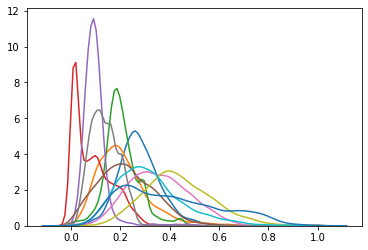

In [22]:
train_x, train_y, test_x, test_y = loadDataset()

for i in range(train_x.shape[0]):
    sns.kdeplot(train_x[i])

print(train_x)